In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
print(load_dotenv(dotenv_path=dotenv_path))

True


In [102]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import scipy.stats as stats
from src.crypto.import_utils import (
    import_crypto_prices_cryptocompare, 
    import_crypto_prices_coingecko,
    fetch_binance_hourly_full_year
)

from src.crypto.utils import (compute_log_returns, 
                              compute_percentage_changes,
                              adf_test,
                              kpss_test
)

In [64]:
# CryptoCompare OHLCV for HBAR
symbol = "HBAR"
market = "USDT"   # or "USDT"
interval = 'histoday'  # 'histominute', 'histohour', 'histoday'
limit = 365*3     # number of candles
aggregate = 1    # candle size multiplier
data = import_crypto_prices_cryptocompare(symbol=symbol,interval=interval, aggregate=aggregate, market=market, limit=limit)
df = data.drop(columns=["conversionType", "conversionSymbol"])

In [65]:
df

,timestamp,high,low,open,volume_base,volume_quote,close
0,2022-12-17,0.04314,0.04095,0.04210,8.844596e+07,3737603.15,0.04301
1,2022-12-18,0.04428,0.04291,0.04301,8.607930e+07,3765852.78,0.04379
2,2022-12-19,0.04434,0.04012,0.04379,1.123599e+08,4796016.25,0.04086
3,2022-12-20,0.04288,0.04070,0.04086,1.163405e+08,4903631.27,0.04283
4,2022-12-21,0.04337,0.04203,0.04283,1.107806e+08,4723746.16,0.04271
...,...,...,...,...,...,...,...
1091,2025-12-12,0.13160,0.12330,0.12990,2.924352e+08,37098951.27,0.12390
1092,2025-12-13,0.12630,0.12120,0.12390,1.948746e+08,24088101.51,0.12300
1093,2025-12-14,0.12450,0.11750,0.12300,2.243368e+08,27051237.31,0.11820
1094,2025-12-15,0.12170,0.11140,0.11820,3.109906e+08,35978971.90,0.11420


<Figure size 1200x600 with 0 Axes>

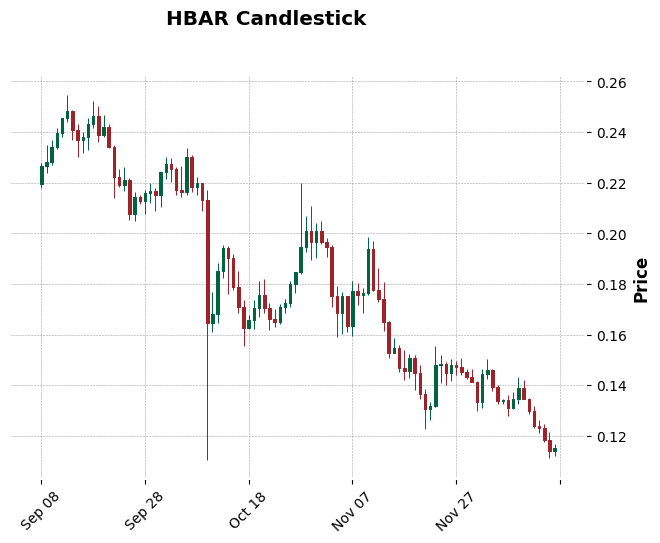

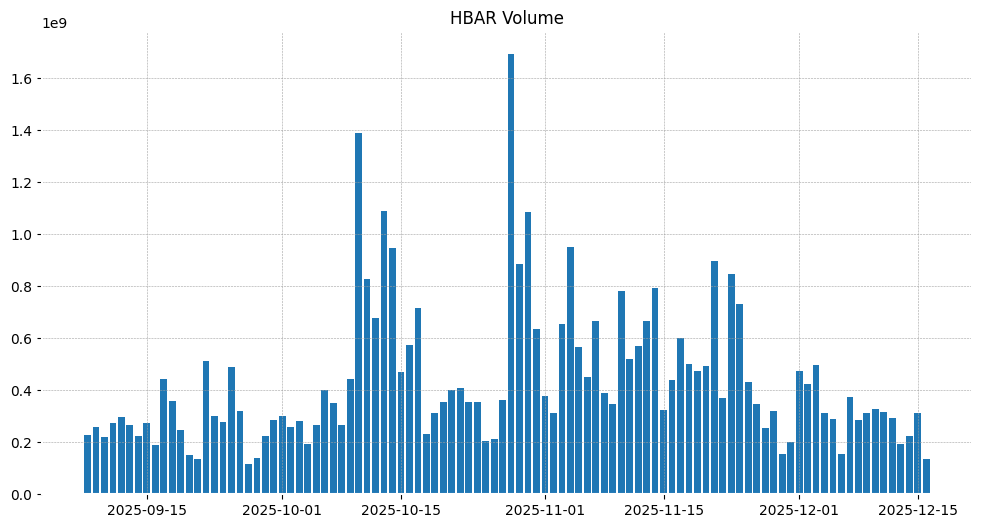

In [66]:
plt.figure(figsize=(12,6))
df_plot = df[-100:].copy()
df_plot = df_plot.set_index("timestamp")

# ---- Candlestick chart ----
mpf.plot(
    df_plot,
    type="candle",
    style="charles",
    volume=False,
    title="HBAR Candlestick"
)

# ---- Volume chart (separate) ----
plt.figure(figsize=(12,6))
plt.bar(df_plot.index, df_plot["volume_base"], width=0.8)
plt.title("HBAR Volume")
plt.show()


In [67]:
df['pct_change']  = compute_percentage_changes(df['close'])
df['log_return']= compute_log_returns(df['close'])
df = df.dropna()

In [68]:
df['pct_change'].mul(100).describe()

count    1095.000000
mean        0.236520
std         5.722312
min       -22.816901
25%        -2.529322
50%        -0.187032
75%         2.140310
max        72.989714
Name: pct_change, dtype: float64

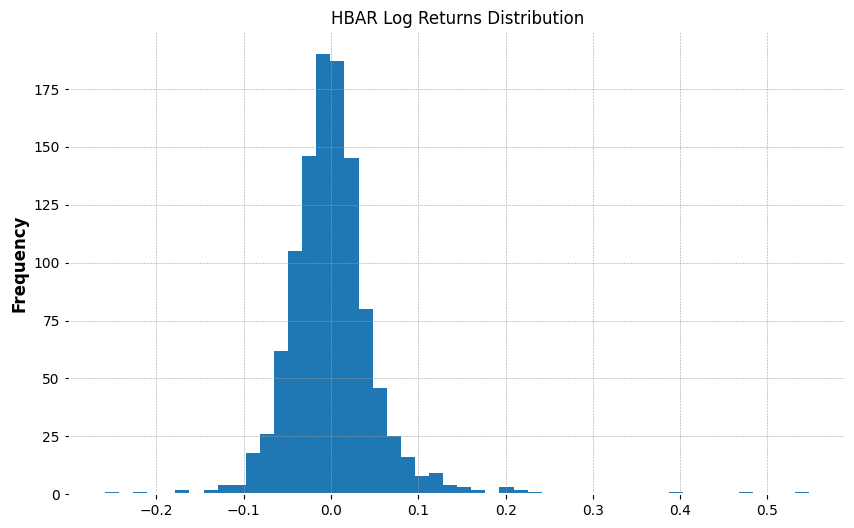

In [69]:
df.log_return.plot(kind='hist', bins=50, figsize=(10,6), title="HBAR Log Returns Distribution")
plt.show()

In [70]:
# Find all candles where the open price is greater than the previous close price
df[(df.open - df.close.shift()) > 0]

,timestamp,high,low,open,volume_base,volume_quote,close,pct_change,log_return
70,2023-02-25,0.07796,0.07218,0.07719,1.322058e+08,9937273.25,0.07499,-0.027619,-0.028008


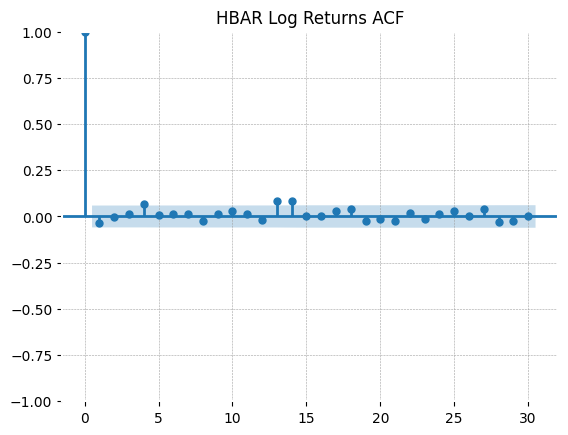

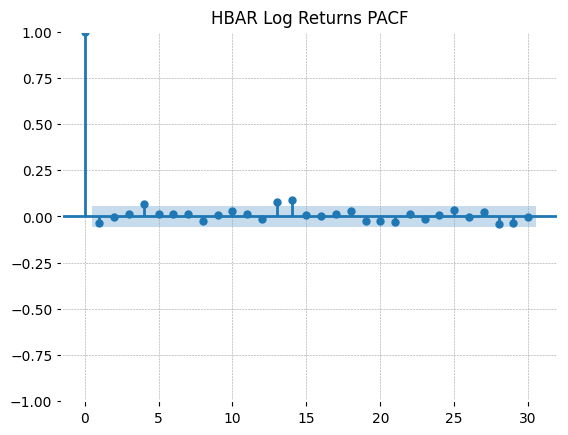

In [71]:
plot_acf(df['log_return'], lags=30, title="HBAR Log Returns ACF");
plot_pacf(df['log_return'], lags=30, title="HBAR Log Returns PACF");

In [72]:
# Perform ADF test: time series stationarity test
adf_test(df['log_return'])
print("\n")
# Perform KPSS test: time series stationarity test
kpss_test(df['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                  -34.244565
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1094.000000
Critical Value (1%)              -3.436342
Critical Value (5%)              -2.864186
Critical Value (10%)             -2.568179
dtype: float64


Results of KPSS Test:
Test Statistic           0.094245
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


D:\My Files\Projects\Python\trade-tools\src\crypto\utils.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [106]:
# example: first 1000 hours
df = fetch_binance_hourly_full_year()


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548 entries, 0 to 17547
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_stamp  17548 non-null  datetime64[ns]
 1   open        17548 non-null  object        
 2   high        17548 non-null  object        
 3   low         17548 non-null  object        
 4   close       17548 non-null  object        
 5   volume      17548 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 822.7+ KB
